In [18]:
import pandas as pd, numpy as np
import statsmodels.api as sm

# ---------- utilities ----------
def to_monthly(price: pd.Series) -> pd.Series:
    # month-end samples
    return price.resample('M').last()

def forward_return(monthly_price: pd.Series, h: int) -> pd.Series:
    return np.log(monthly_price.shift(-h)) - np.log(monthly_price)

def bias(price: pd.Series, n: int) -> pd.Series:
    ma = price.rolling(n).mean()
    return (price - ma) / ma

# ---------- patched panel builder ----------
def prepare_panel(price_daily: pd.Series) -> pd.DataFrame:
    price_daily = price_daily.dropna()
    if not isinstance(price_daily.index, pd.DatetimeIndex):
        price_daily.index = pd.to_datetime(price_daily.index)
    price_daily = price_daily.tz_localize(None)

    # Monthly close
    px_m = price_daily.resample('ME').last()

    # 250d BIAS on daily, then month-end sample
    ma250 = price_daily.rolling(250, min_periods=200).mean()
    bias250_m = ((price_daily - ma250) / ma250).resample('ME').last()

    # 12–1 momentum (uses monthly px)
    mom_12_1 = (np.log(px_m.shift(1)) - np.log(px_m.shift(12)))

    # 20d realized vol (daily), then month-end sample
    vol20_m = price_daily.pct_change().rolling(20, min_periods=15).std().resample('ME').last()

    df = pd.concat(
        {'px': px_m, 'bias250': bias250_m, 'mom_12_1': mom_12_1, 'vol20': vol20_m},
        axis=1
    ).dropna()

    for h in [1,3,6,12]:
        df[f'fr_{h}m'] = np.log(df['px'].shift(-h)) - np.log(df['px'])
    return df.dropna()


def bin_by_quantile(x: pd.Series, k=10, lb=240):
    ranks = x.expanding(lb).apply(lambda s: pd.Series(s).rank(pct=True).iloc[-1]).dropna()
    return np.ceil(ranks*k).clip(1,k).astype(int)

def quantile_stats(df, k=10, horizon=12):
    q = bin_by_quantile(df['bias250'])
    out = df.groupby(q)[f'fr_{horizon}m'].agg(['mean','median', 'max', 'min', 'std', 'count'])
    out['ann_mean'] = out['mean'] * (12/horizon)
    return out

# ---------- strategy bits from earlier ----------
def bias_weight(bias250: pd.Series, lb=252*10, lo_q=0.1, hi_q=0.9, floor=0.2, cap=1.0, hysteresis=True):
    roll = bias250.rolling(lb, min_periods=240)
    q = roll.apply(lambda s: pd.Series(s).rank(pct=True).iloc[-1])
    w_raw = 1 - q
    if hysteresis:
        hi = (q > hi_q).rolling(2).sum() == 2
        lo = (q < lo_q).rolling(2).sum() == 2
        w = w_raw.copy()
        w[hi] = np.minimum(w[hi], 0.4)
        w[lo] = np.maximum(w[lo], 0.9)
    else:
        w = w_raw
    return w.clip(floor, cap)

def backtest_equity_tilt(px_m: pd.Series, w: pd.Series, cost_bps=5):
    ret = px_m.pct_change().fillna(0.0)
    w = w.reindex(ret.index).ffill().fillna(1.0)
    turn = w.diff().abs().fillna(0.0)
    net = w * ret - (turn * cost_bps/1e4)
    curve = (1+net).cumprod()
    return pd.DataFrame({'ret': net, 'w': w, 'curve': curve})

def nw_ols(y: pd.Series, X: pd.DataFrame, lags: int = 6):
    # 1) Align and clean
    Z = pd.concat([y.rename('y'), X], axis=1)
    Z = Z.replace([np.inf, -np.inf], np.nan).dropna()

    # 2) Make sure we actually have data
    if Z.empty or Z.shape[0] < (lags + 5):  # need some cushion vs HAC lags
        raise ValueError(
            f"No valid observations for OLS after alignment/NaN drop. "
            f"Found rows={Z.shape[0]}. "
            f"Check input columns for NaNs (esp. bias250, mom_12_1, vol20) "
            f"and that your history spans at least ~2 years."
        )

    X1 = sm.add_constant(Z.drop(columns='y'))
    model = sm.OLS(Z['y'], X1, missing='drop').fit(
        cov_type='HAC', cov_kwds={'maxlags': lags}
    )
    return model, Z

In [23]:
import yfinance as yf

# 1) daily close as a Series
close_df = yf.download('^GSPC', start='1980-01-01')
close_df = close_df['Close'].squeeze()
close_df

/var/folders/y9/2slpdtcd62sccy809rd8q1pc0000gn/T/ipykernel_54739/2092298572.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  close_df = yf.download('^GSPC', start='1980-01-01')
[*********************100%***********************]  1 of 1 completed


Date
1980-01-02     105.760002
1980-01-03     105.220001
1980-01-04     106.519997
1980-01-07     106.809998
1980-01-08     108.949997
                 ...     
2025-10-23    6738.439941
2025-10-24    6791.689941
2025-10-27    6875.160156
2025-10-28    6890.890137
2025-10-29    6890.589844
Name: ^GSPC, Length: 11552, dtype: float64

In [24]:
# 2) build panel (do NOT slice to [['Close']])
df = prepare_panel(close_df)
df

,px,bias250,mom_12_1,vol20,fr_1m,fr_3m,fr_6m,fr_12m
Date,,,,,,,,
1981-01-31,129.550003,0.073950,0.173288,0.008744,0.013189,0.024853,0.010520,-0.073247
1981-02-28,131.270004,0.079272,0.130855,0.009047,0.035399,0.010005,-0.066781,-0.148896
1981-03-31,136.000000,0.095136,0.251402,0.009831,-0.023735,-0.035856,-0.157514,-0.194513
1981-04-30,132.809998,0.047369,0.246484,0.006393,-0.001658,-0.014333,-0.085801,-0.131543
1981-05-31,132.589996,0.030254,0.177230,0.006965,-0.010462,-0.076786,-0.048206,-0.169835
...,...,...,...,...,...,...,...,...
2024-06-30,5460.479980,0.140228,0.170465,0.004173,0.011258,0.053831,0.074297,0.127811
2024-07-31,5522.299805,0.131787,0.173883,0.009464,0.022578,0.032627,0.089697,0.137988
2024-08-31,5648.399902,0.136595,0.203016,0.011472,0.019996,0.065769,0.052775,0.134297


             mean    median       max       min       std  count  ann_mean
bias250                                                                   
1.0      0.038583  0.089218  0.429927 -0.593415  0.255979     38  0.038583
2.0     -0.023532  0.096025  0.361603 -0.512338  0.242031     27 -0.023532
3.0      0.059837  0.124792  0.307815 -0.502359  0.193322     27  0.059837
4.0      0.092394  0.087959  0.326538 -0.138904  0.126951     26  0.092394
5.0      0.116970  0.104075  0.342447 -0.102264  0.102081     28  0.116970
6.0      0.055432  0.089375  0.204430 -0.469604  0.130720     36  0.055432
7.0      0.089072  0.104960  0.295394 -0.183436  0.105175     41  0.089072
8.0      0.099335  0.135668  0.225594 -0.216203  0.104758     27  0.099335
9.0      0.085794  0.119500  0.209523 -0.173459  0.087149     20  0.085794
10.0     0.083386  0.086118  0.256253 -0.134124  0.120580     17  0.083386
                            OLS Regression Results                            
Dep. Variable:       

Text(0.5, 1.0, 'BIAS-weighted equity tilt')

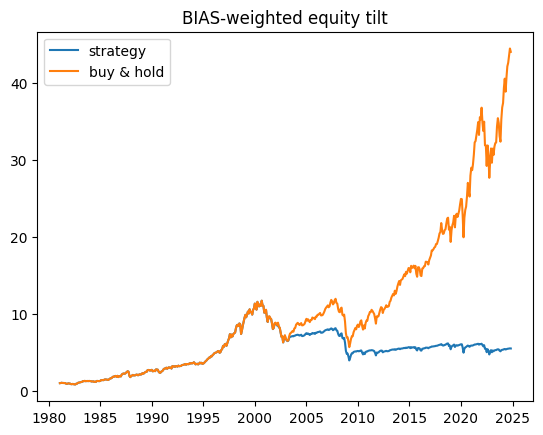

In [25]:
import matplotlib.pyplot as plt

# 3) descriptive predictive bins
print(quantile_stats(df, k=10, horizon=12))

# 4) predictive regression (12m)
reg, Z = nw_ols(df['fr_12m'], df[['bias250','mom_12_1','vol20']])
print(reg.summary())

# 5) strategy backtest
w = bias_weight(df['bias250'])
bt = backtest_equity_tilt(df['px'], w)
plt.plot(bt['curve'], label='strategy')
plt.plot(df['px'] / df['px'].iloc[0], label='buy & hold')
plt.legend()
plt.title('BIAS-weighted equity tilt')